# Introducción {.unnumbered}

Este documento analiza flujos de datos (*data streams*) utilizando el dataset [`Elec2`](https://riverml.xyz/latest/api/datasets/Elec2/), que contiene información sobre precios de electricidad en Nueva Gales del Sur, Australia. Este conjunto de datos es ideal para evaluar algoritmos de aprendizaje automático debido a su naturaleza temporal y compleja.

Se utiliza la biblioteca de Python [River](https://riverml.xyz) para implementar y evaluar algoritmos de clasificación, detección de concept drift y clustering.

El documento está organizado en cuatro secciones principales (asociadas a cada uno de los ejercicios propuestos) además de la introducción: [Técnica de Evaluación: *Holdout*](#holdout), [Técnica de Evaluación: *Prequential*](#prequential), [Detección de *Concept Drift*](#drift) y [Técnicas de *Clustering*](#clustering).

::: {.callout-note}
## Creación del Documento

El Jupyter Notebook ha sido convertido a un documento PDF utilizando [Quarto](https://quarto.org/). Algunas celdas, como las que contienen código para mostrar gráficos y ciertos resultados, se han ocultado para evitar redundancias y mantener el documento limpio.
:::

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from river import datasets
from river import metrics
from river import preprocessing
from river import compose

from river import cluster
from river import tree
from river import neighbors

from river import utils

from river import drift

- https://riverml.xyz/latest/api/datasets/Elec2/
- https://www.kaggle.com/datasets/gauravduttakiit/electricity-prices-in-new-south-wales


In [3]:
dataset = datasets.Elec2()
print(dataset)

Electricity prices in New South Wales.

This is a binary classification task, where the goal is to predict if the price of electricity
will go up or down.

This data was collected from the Australian New South Wales Electricity Market. In this market,
prices are not fixed and are affected by demand and supply of the market. They are set every
five minutes. Electricity transfers to/from the neighboring state of Victoria were done to
alleviate fluctuations.

References
----------
[^1]: [SPLICE-2 Comparative Evaluation: Electricity Pricing](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.12.9405)
[^2]: [DataHub description](https://datahub.io/machine-learning/electricity#readme)

      Name  Elec2                                                      
      Task  Binary classification                                      
   Samples  45,312                                                     
  Features  8                                                          
    Sparse  False 

In [4]:
dataset = datasets.Elec2()
dataset = list(dataset)
dataset = [{**x, "target": y} for (x, y) in dataset]
dataset_df = pd.DataFrame(dataset)
dataset_df.head(10)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,target
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,True
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,True
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,True
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,True
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,False
5,0.0,2,0.106383,0.041161,0.207528,0.003467,0.422915,0.414912,False
6,0.0,2,0.127660,0.041161,0.171824,0.003467,0.422915,0.414912,False
7,0.0,2,0.148936,0.041161,0.152782,0.003467,0.422915,0.414912,False
8,0.0,2,0.170213,0.041161,0.134930,0.003467,0.422915,0.414912,False
9,0.0,2,0.191489,0.041161,0.140583,0.003467,0.422915,0.414912,False


In [5]:
# index_summary = dataset_df.index.to_series().describe()
summary = dataset_df.describe().loc[["count", "mean", "std", "min", "max"]]
summary.loc["unique"] = dataset_df.nunique()
# summary["index"] = index_summary
summary

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,4.003178,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526
std,0.340308,1.998695,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
unique,933.000000,7.000000,48.000000,4089.000000,5266.000000,3798.000000,2846.000000,1878.000000


In [6]:
# target class balance
dataset_df["target"].value_counts(normalize=True)

target
False    0.575455
True     0.424545
Name: proportion, dtype: float64

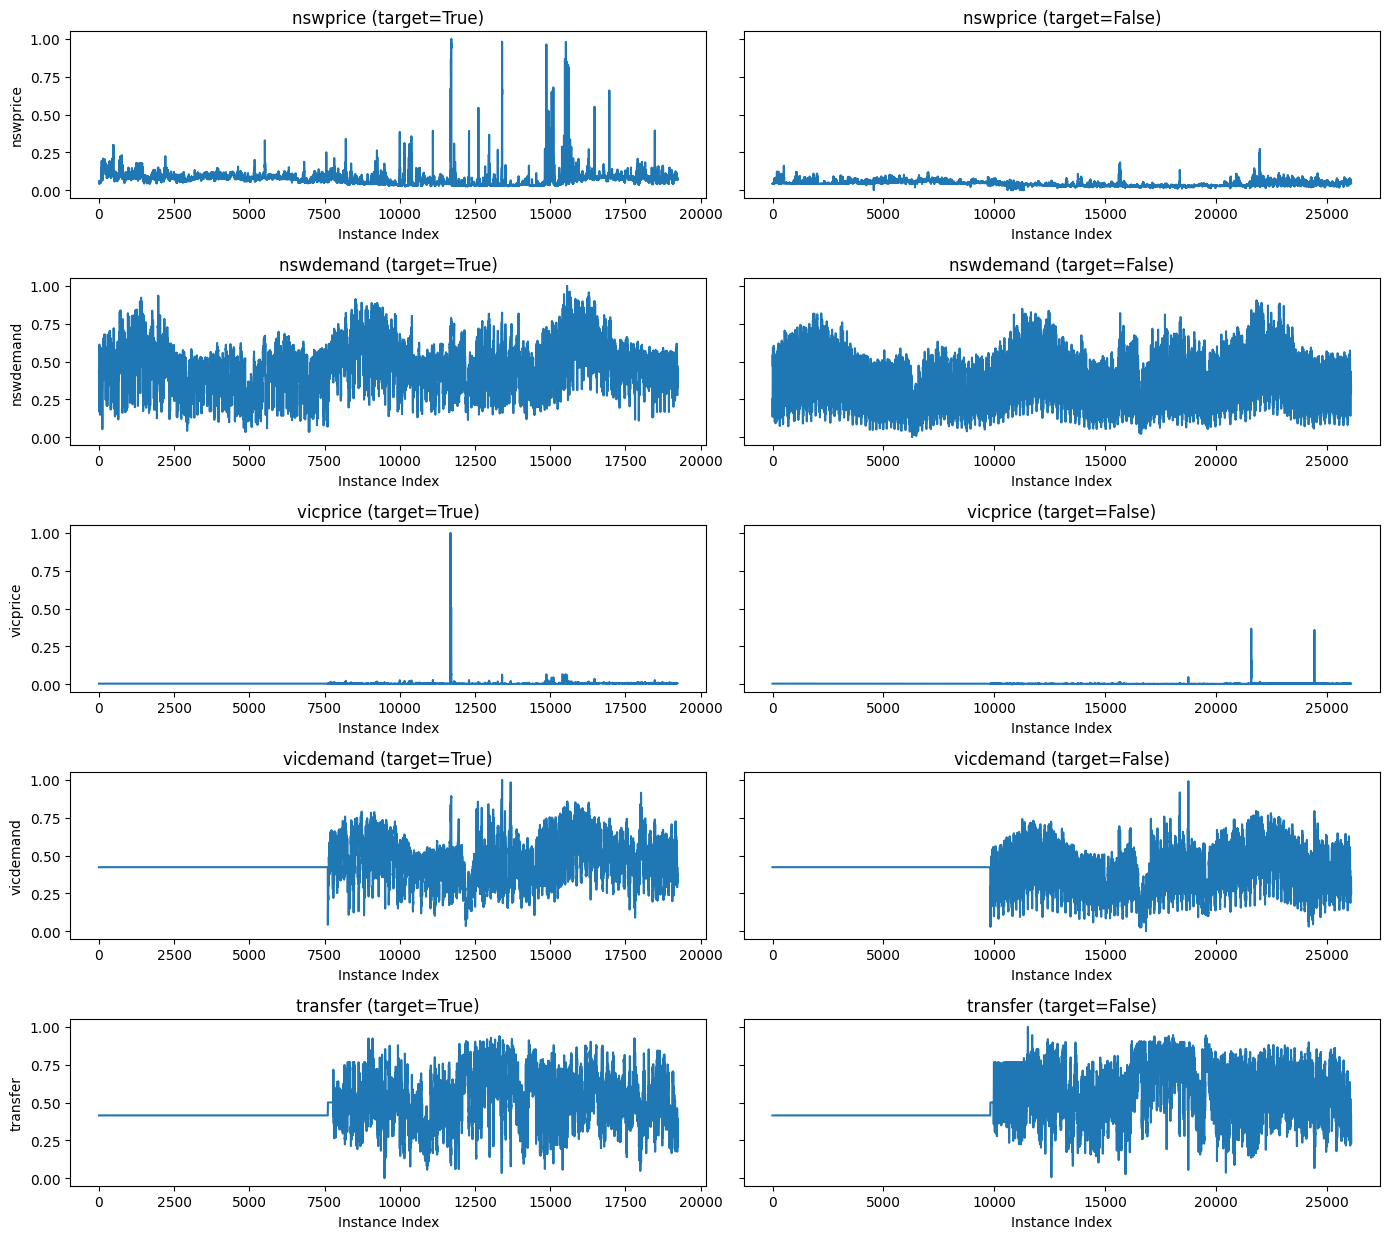

In [7]:
time_vars = {"date", "period", "day"}
plot_vars = [
    col for col in dataset_df.columns if col not in time_vars and col != "target"
]

n_vars = len(plot_vars)
fig, axes = plt.subplots(
    n_vars, 2, figsize=(14, 2.5 * n_vars), sharex=False, sharey="row"
)

for i, var in enumerate(plot_vars):
    for j, target_val in enumerate([True, False]):
        ax = axes[i, j]
        subset = dataset_df[dataset_df["target"] == target_val].reset_index(drop=True)

        sns.lineplot(data=subset, x=subset.index, y=var, ax=ax)
        ax.set_title(f"{var} (target={target_val})")
        ax.set_xlabel("Instance Index")
        ax.set_ylabel(var if j == 0 else "")

plt.tight_layout()
plt.show()

In [8]:
dataset = datasets.Elec2()
features = ["nswprice", "nswdemand", "vicprice", "vicdemand"]
adwins = {f: drift.ADWIN() for f in features}
drift_points = {f: [] for f in features}
values = {f: [] for f in features}
time_steps = []

for i, (x, _) in enumerate(dataset):
    time_steps.append(i)
    for f in features:
        val = x[f]
        values[f].append(val)
        adwin = adwins[f]
        adwin.update(val)
        if adwin.drift_detected:
            drift_points[f].append(i)

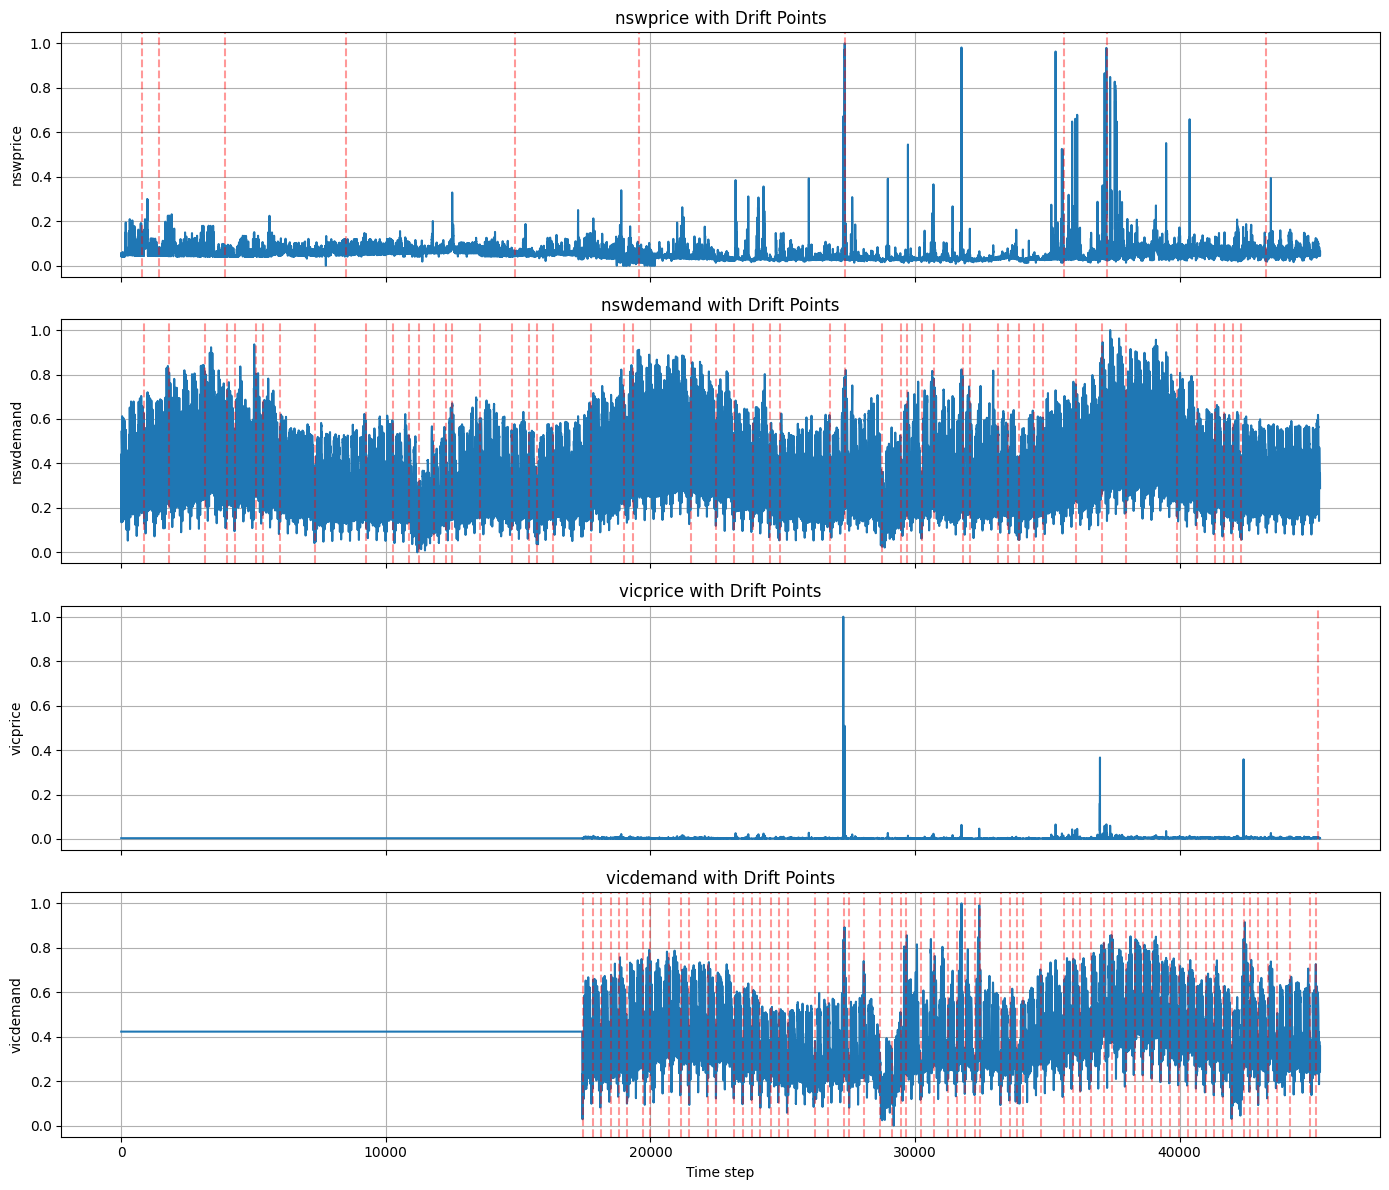

In [9]:
fig, axes = plt.subplots(len(features), 1, figsize=(14, 3 * len(features)), sharex=True)

for i, f in enumerate(features):
    ax = axes[i]
    ax.plot(time_steps, values[f], label=f"{f}")
    for drift_time in drift_points[f]:
        ax.axvline(x=drift_time, color="red", linestyle="--", alpha=0.4)
    ax.set_title(f"{f} with Drift Points")
    ax.set_ylabel(f)
    ax.grid(True)

axes[-1].set_xlabel("Time step")
plt.tight_layout()
plt.show()

# Técnica de Evaluación: *Holdout* {#holdout}

In [10]:
def train_holdout(
    model, stream, metric_list, evaluation_interval=1000, test_window_size=300
):

    stream_iter = iter(stream)
    steps = []
    results = []

    i = 1
    try:
        while True:
            x, y = next(stream_iter)
            model.learn_one(x, y)
            i += 1

            if (i + test_window_size) % evaluation_interval == 0:
                test_set = [next(stream_iter) for _ in range(test_window_size)]

                for metric in metric_list:
                    metric.__init__()

                for x_test, y_test in test_set:
                    y_pred = model.predict_one(x_test)
                    for metric in metric_list:
                        if y_pred is not None:
                            metric.update(y_test, y_pred)

                i += test_window_size
                steps.append(i)
                results.append([metric.get() for metric in metric_list])

    except StopIteration:
        pass

    return steps, results

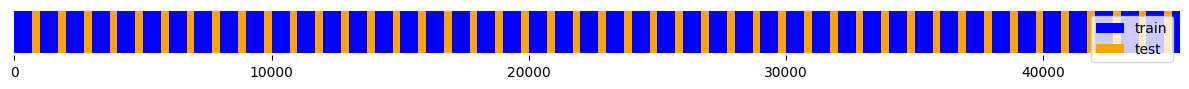

In [11]:
datatset_list = list(datasets.Elec2())
dataset_length = len(datatset_list)

color_map = {"train": "blue", "test": "orange"}

steps_split = [("train" if (i % 1000) < 700 else "test") for i in range(dataset_length)]

segments = []
current = steps_split[0]
start = 0

for i, val in enumerate(steps_split):
    if val != current:
        segments.append((start, i - start, current))
        current = val
        start = i

segments.append((start, len(steps_split) - start, current))

fig, ax = plt.subplots(figsize=(12, 1))
for start, length, label in segments:
    ax.barh(
        0,
        width=length,
        left=start,
        color=color_map[label],
        edgecolor="none",
        label=(
            label
            if label
            not in [
                seg[2] for seg in segments[: segments.index((start, length, label))]
            ]
            else None
        ),
    )

ax.set_xlim(0, dataset_length)
ax.set_yticks([])
ax.set_xticks(range(0, dataset_length + 1, 10000))
ax.set_xticklabels(range(0, dataset_length + 1, 10000))
ax.set_frame_on(False)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [12]:
def plot_evaluation_results(
    steps, results, metric_names, figure_title, drift_points=None
):
    transposed = list(zip(*results))
    num_metrics = len(transposed)

    # Use provided metric names or generate defaults
    if metric_names is None or len(metric_names) != num_metrics:
        metric_names = [f"Metric {i+1}" for i in range(num_metrics)]

    plt.figure(figsize=(12, 6))

    # Plot metrics
    for i, metric_values in enumerate(transposed):
        plt.plot(steps, metric_values, marker="o", label=metric_names[i])

    # Add drift points if provided
    if drift_points:
        for drift_time in drift_points:
            plt.axvline(x=drift_time, color="red", linestyle="--", alpha=0.4)

        # Add a label for drift in the legend
        plt.axvline(
            x=-1, color="red", linestyle="--", alpha=0.4, label="Drift detected"
        )

    plt.title(figure_title)
    plt.xlabel("Training steps")
    plt.ylabel("Metric values")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
datatset_stream = datasets.Elec2()
hoeffding_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.HoeffdingTreeClassifier(),
)
metrics_list = [metrics.Accuracy(), metrics.F1(pos_val=True)]

hoeffding_holdout_steps, hoeffding_holdout_results = train_holdout(
    hoeffding_model, datatset_stream, metrics_list
)

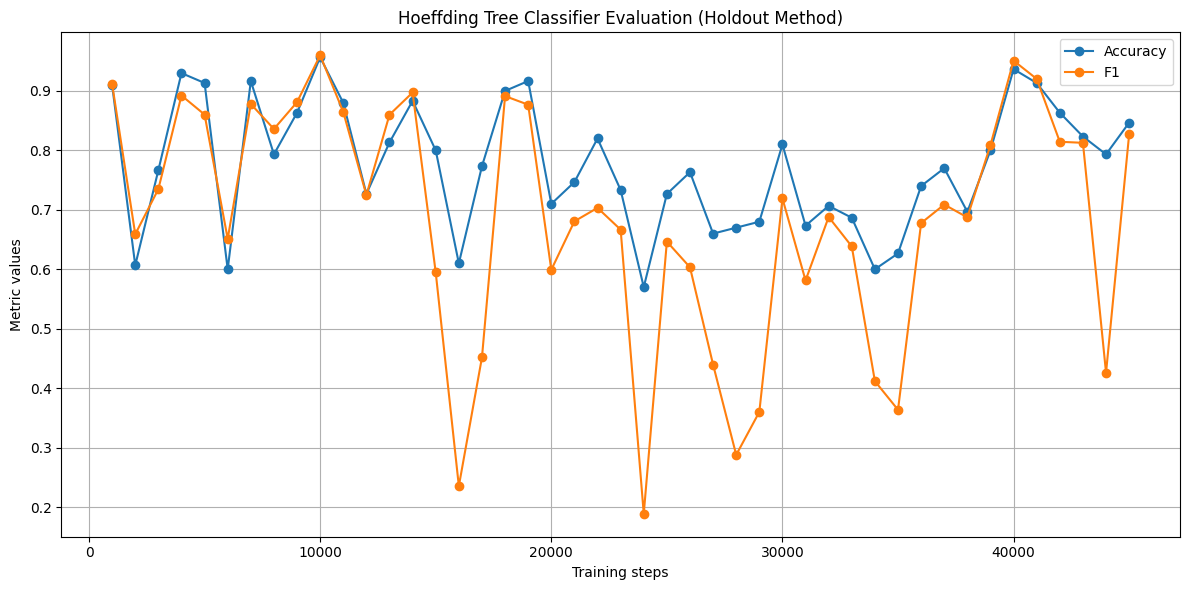

In [14]:
plot_evaluation_results(
    hoeffding_holdout_steps,
    hoeffding_holdout_results,
    metric_names=["Accuracy", "F1"],
    figure_title="Hoeffding Tree Classifier Evaluation (Holdout Method)",
)

In [15]:
datatset_stream = datasets.Elec2()
neighbors_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    neighbors.KNNClassifier(),
)
metrics_list = [metrics.Accuracy(), metrics.F1(pos_val=True)]

neighbors_holdout_steps, neighbors_holdout_results = train_holdout(
    neighbors_model, datatset_stream, metrics_list
)

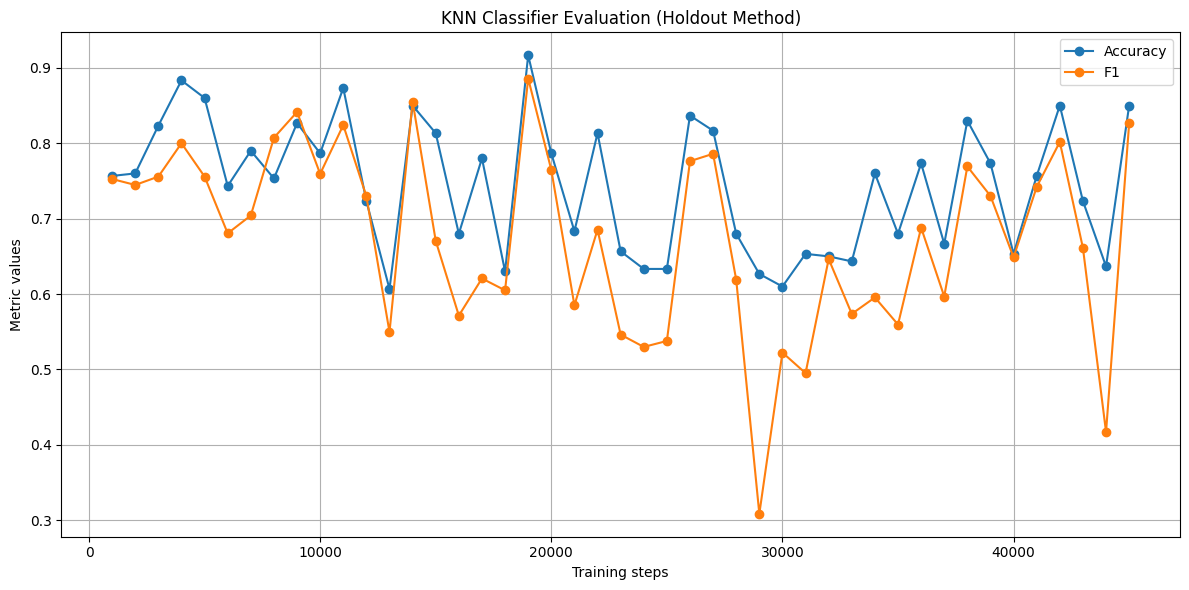

In [16]:
plot_evaluation_results(
    neighbors_holdout_steps,
    neighbors_holdout_results,
    metric_names=["Accuracy", "F1"],
    figure_title="KNN Classifier Evaluation (Holdout Method)",
)

In [17]:
def compare_model_results(model_names, results_list, metric_names, evaluation_type):

    summary_data = {"Model": model_names}

    for i, metric_name in enumerate(metric_names):
        mean_values = []
        last_values = []

        for results in results_list:
            metric_values = [result[i] for result in results]
            mean_value = sum(metric_values) / len(metric_values)
            last_value = results[-1][i]

            mean_values.append(mean_value)
            last_values.append(last_value)

        summary_data[f"Mean {metric_name}"] = mean_values
        summary_data[f"Last {metric_name}"] = last_values

    results_table = pd.DataFrame(summary_data)

    styled_table = results_table.style.format(
        {col: "{:.2%}" for col in results_table.columns if col != "Model"}
    )
    display(styled_table)

    num_models = len(model_names)
    num_metrics = len(metric_names)

    plt.figure(figsize=(10, 6))

    bar_width = 0.8 / (num_metrics * 2)
    index = np.arange(num_models)

    colors = [plt.cm.Set1(i) for i in range(num_metrics)]
    light_colors = [plt.cm.colors.to_rgba(color, alpha=0.6) for color in colors]

    for i, metric_name in enumerate(metric_names):
        offset = i * 2 * bar_width - (num_metrics - 1) * bar_width

        mean_pos = index + offset
        mean_values = summary_data[f"Mean {metric_name}"]
        plt.bar(
            mean_pos,
            mean_values,
            width=bar_width,
            label=f"Mean {metric_name}",
            color=colors[i],
        )

        last_pos = index + offset + bar_width
        last_values = summary_data[f"Last {metric_name}"]
        plt.bar(
            last_pos,
            last_values,
            width=bar_width,
            label=f"Last {metric_name}",
            color=light_colors[i],
        )

        for j, (mean_val, last_val) in enumerate(zip(mean_values, last_values)):
            plt.text(
                mean_pos[j],
                mean_val + 0.01,
                f"{mean_val:.2%}",
                ha="center",
                va="bottom",
                fontsize=8,
            )
            plt.text(
                last_pos[j],
                last_val + 0.01,
                f"{last_val:.2%}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title(
        f"Comparison of Model Performance ({evaluation_type.capitalize()} Evaluation)"
    )
    plt.xticks(index, model_names)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

,Model,Mean Accuracy,Last Accuracy,Mean F1,Last F1
0,Hoeffding Tree,77.61%,84.67%,68.61%,82.71%
1,KNN,74.52%,85.00%,67.39%,82.63%


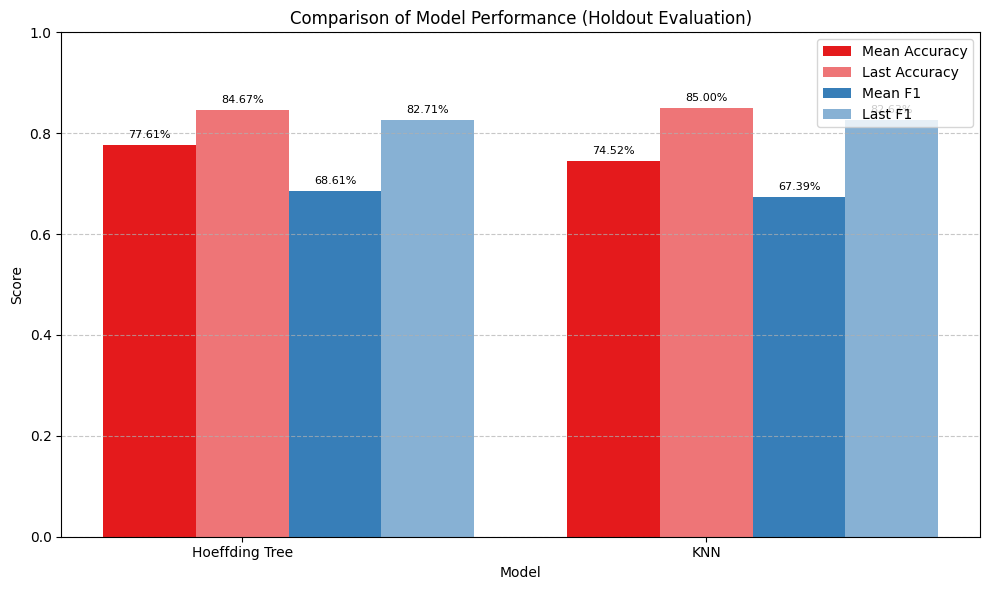

In [18]:
compare_model_results(
    model_names=["Hoeffding Tree", "KNN"],
    results_list=[hoeffding_holdout_results, neighbors_holdout_results],
    metric_names=["Accuracy", "F1"],
    evaluation_type="holdout",
)

# Técnica de Evaluación: *Prequential* {#prequential}

In [19]:
def train_prequential(model, stream, metric_list, evaluation_interval=1000):
    steps = []
    results = []

    for i, (x, y) in enumerate(stream, start=1):
        y_pred = model.predict_one(x)

        for metric in metric_list:
            if y_pred is not None:
                metric.update(y, y_pred)

        if i % evaluation_interval == 0:
            results.append([metric.get() for metric in metric_list])
            steps.append(i)

        model.learn_one(x, y)

    return steps, results

In [20]:
datatset_stream = datasets.Elec2()
hoeffding_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.HoeffdingTreeClassifier(),
)
metrics_list = [
    utils.Rolling(metrics.Accuracy(), window_size=1000),
    utils.Rolling(metrics.F1(pos_val=True), window_size=1000),
]

hoeffding_prequential_steps, hoeffding_prequential_results = train_prequential(
    hoeffding_model, datatset_stream, metrics_list
)

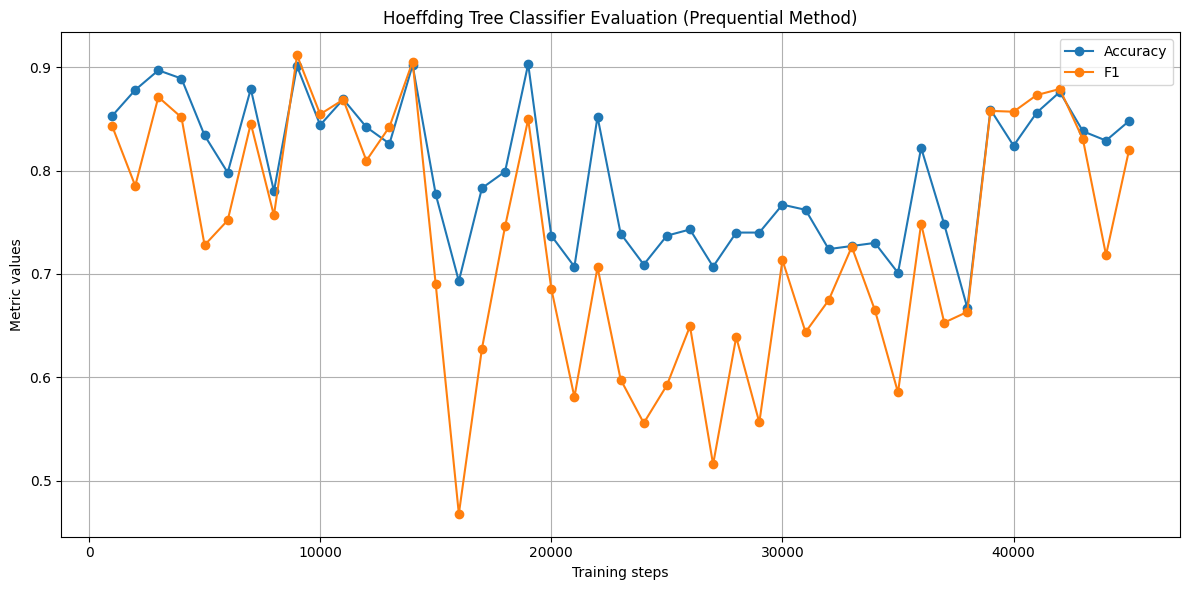

In [21]:
plot_evaluation_results(
    hoeffding_prequential_steps,
    hoeffding_prequential_results,
    metric_names=["Accuracy", "F1"],
    figure_title="Hoeffding Tree Classifier Evaluation (Prequential Method)",
)

In [22]:
datatset_stream = datasets.Elec2()
neighbors_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    neighbors.KNNClassifier(),
)
metrics_list = [
    utils.Rolling(metrics.Accuracy(), window_size=1000),
    utils.Rolling(metrics.F1(pos_val=True), window_size=1000),
]

neighbors_prequential_steps, neighbors_prequential_results = train_prequential(
    neighbors_model, datatset_stream, metrics_list
)

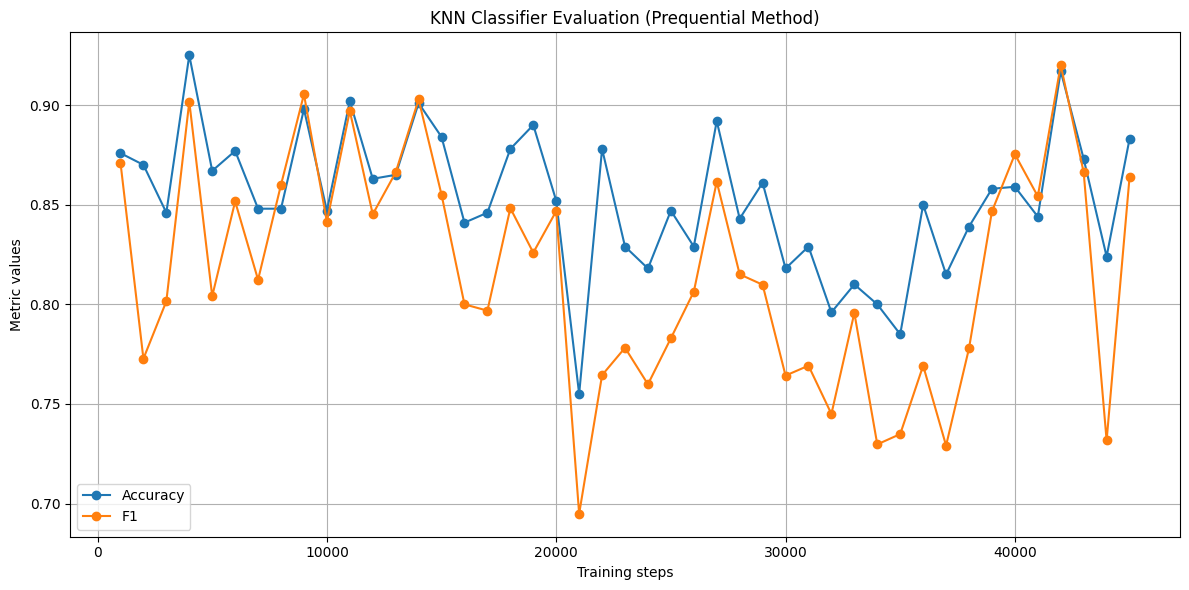

In [23]:
plot_evaluation_results(
    neighbors_prequential_steps,
    neighbors_prequential_results,
    metric_names=["Accuracy", "F1"],
    figure_title="KNN Classifier Evaluation (Prequential Method)",
)

,Model,Mean Accuracy,Last Accuracy,Mean F1,Last F1
0,Hoeffding Tree,79.86%,84.80%,73.32%,82.03%
1,KNN,85.28%,88.30%,81.67%,86.38%


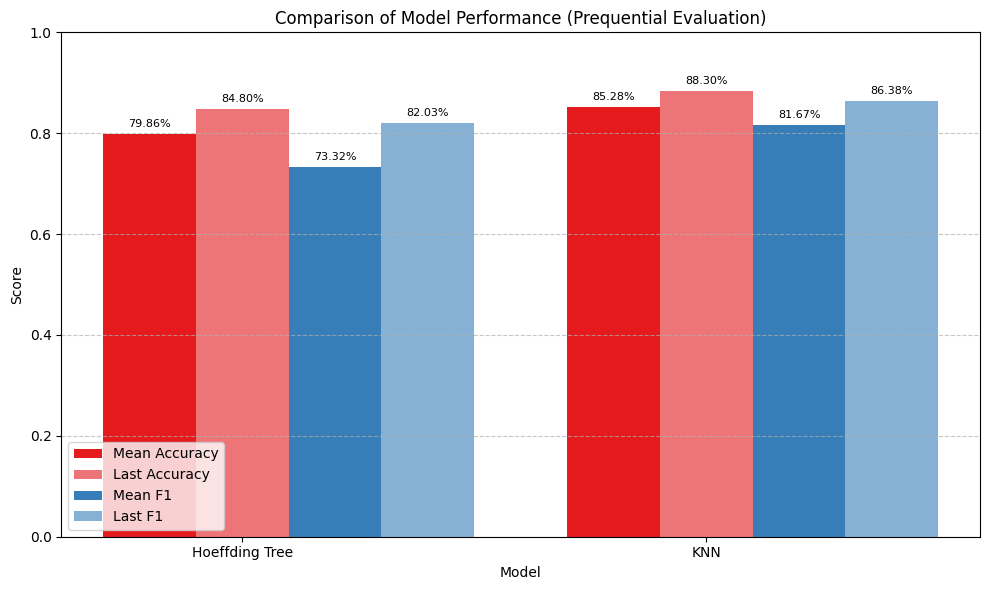

In [24]:
compare_model_results(
    model_names=["Hoeffding Tree", "KNN"],
    results_list=[hoeffding_prequential_results, neighbors_prequential_results],
    metric_names=["Accuracy", "F1"],
    evaluation_type="prequential",
)

# Detección de *Concept Drift* {#drift}

In [25]:
def train_prequential_drift(model, stream, metric_list, evaluation_interval=1000):
    steps = []
    results = []

    # For drift detection
    drift_detector = drift.ADWIN()
    drift_points = []

    for i, (x, y) in enumerate(stream, start=1):
        y_pred = model.predict_one(x)

        for metric in metric_list:
            if y_pred is not None:
                metric.update(y, y_pred)

        # Detect drift in prediction error
        if y_pred is not None:
            error = 0 if y == y_pred else 1
            drift_detector.update(error)
            if drift_detector.drift_detected:
                drift_points.append(i)
                # Reset the detector after drift is detected
                drift_detector = drift.ADWIN()

        if i % evaluation_interval == 0:
            results.append([metric.get() for metric in metric_list])
            steps.append(i)

        model.learn_one(x, y)

    return steps, results, drift_points

In [26]:
datatset_stream = datasets.Elec2()
hoeffding_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.HoeffdingTreeClassifier(),
)
metrics_list = [
    utils.Rolling(metrics.Accuracy(), window_size=1000),
    utils.Rolling(metrics.F1(pos_val=True), window_size=1000),
]

(
    hoeffding_prequential_drift_steps,
    hoeffding_prequential_drift_results,
    hoeffding_drift_points,
) = train_prequential_drift(hoeffding_model, datatset_stream, metrics_list)

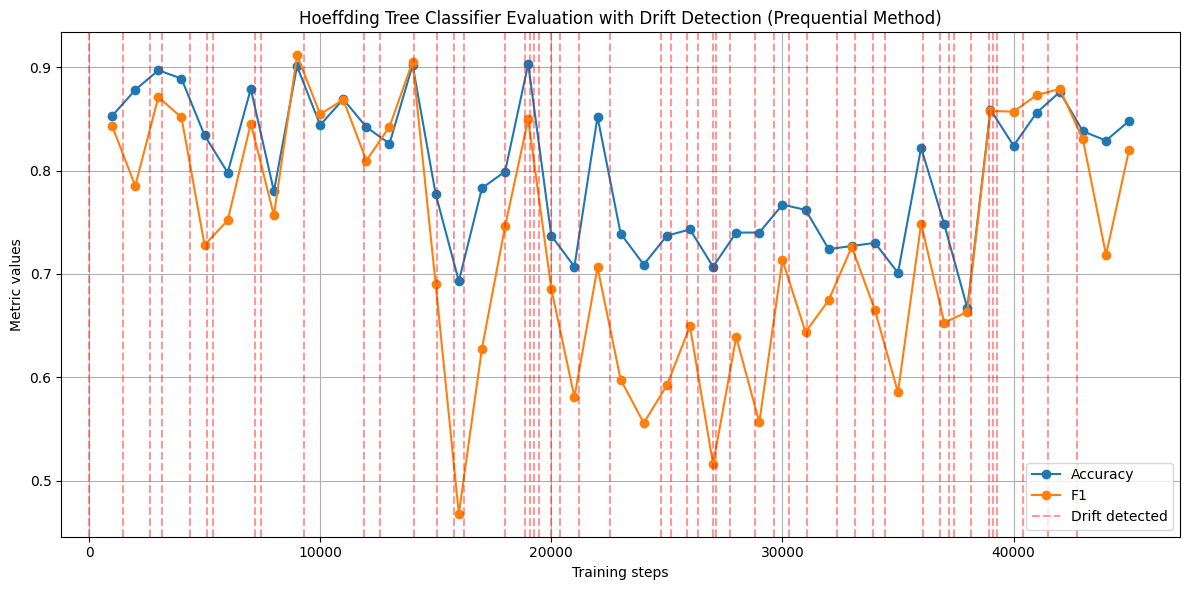

In [27]:
plot_evaluation_results(
    hoeffding_prequential_drift_steps,
    hoeffding_prequential_drift_results,
    metric_names=["Accuracy", "F1"],
    figure_title="Hoeffding Tree Classifier Evaluation with Drift Detection (Prequential Method)",
    drift_points=hoeffding_drift_points,
)

In [28]:
datatset_stream = datasets.Elec2()
neighbors_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    neighbors.KNNClassifier(),
)
metrics_list = [
    utils.Rolling(metrics.Accuracy(), window_size=1000),
    utils.Rolling(metrics.F1(pos_val=True), window_size=1000),
]

neighbors_prequential_steps, neighbors_prequential_results, neighbors_drift_points = (
    train_prequential_drift(neighbors_model, datatset_stream, metrics_list)
)

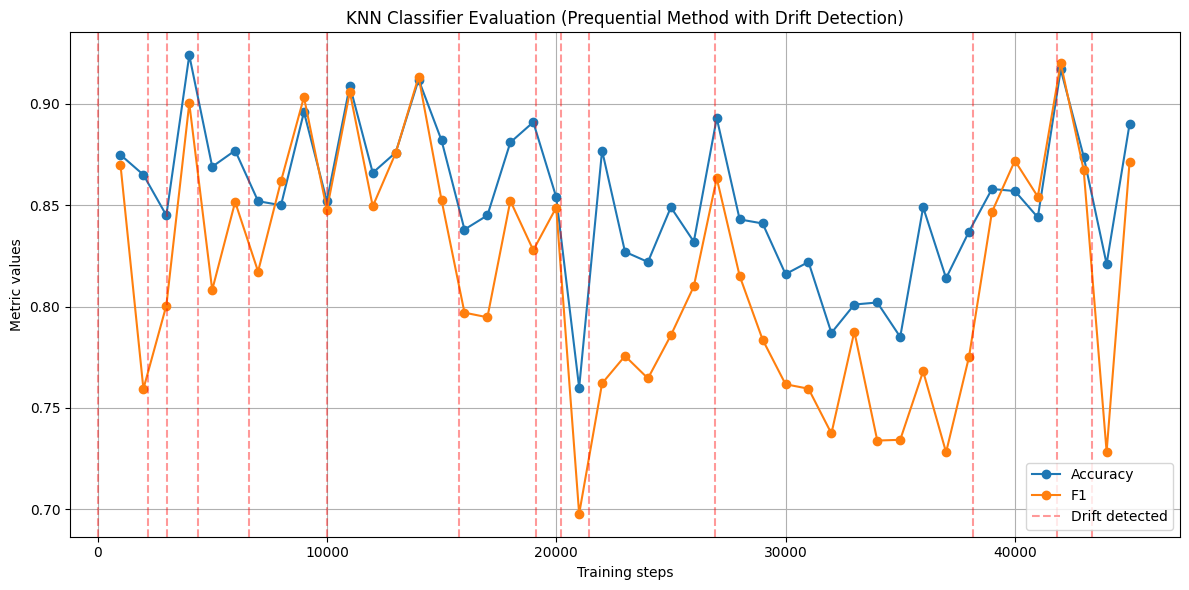

In [29]:
plot_evaluation_results(
    neighbors_prequential_steps,
    neighbors_prequential_results,
    metric_names=["Accuracy", "F1"],
    figure_title="KNN Classifier Evaluation (Prequential Method with Drift Detection)",
    drift_points=neighbors_drift_points,
)

# Técnicas de *Clustering* {#clustering}

In [43]:
def train_clustering(model, stream, metrics_list, evaluation_interval=1000):
    steps = []
    results = []

    for i, (x, y) in enumerate(stream, start=1):
        y_pred = model.predict_one(x)

        for metric in metrics_list:
            if len(model.centers) > 1 and y_pred >= 0:
                    metric.update(x, y_pred, model.centers)

        if i % evaluation_interval == 0:
            results.append([metric.get() for metric in metrics_list])
            steps.append(i)

        model.learn_one(x)

    return steps, results

In [44]:
datatset_stream = datasets.Elec2()
clustream_model = cluster.CluStream()
metrics_list = [metrics.Silhouette()]

clustream_steps, clustream_results = train_clustering(
    clustream_model, datatset_stream, metrics_list
)

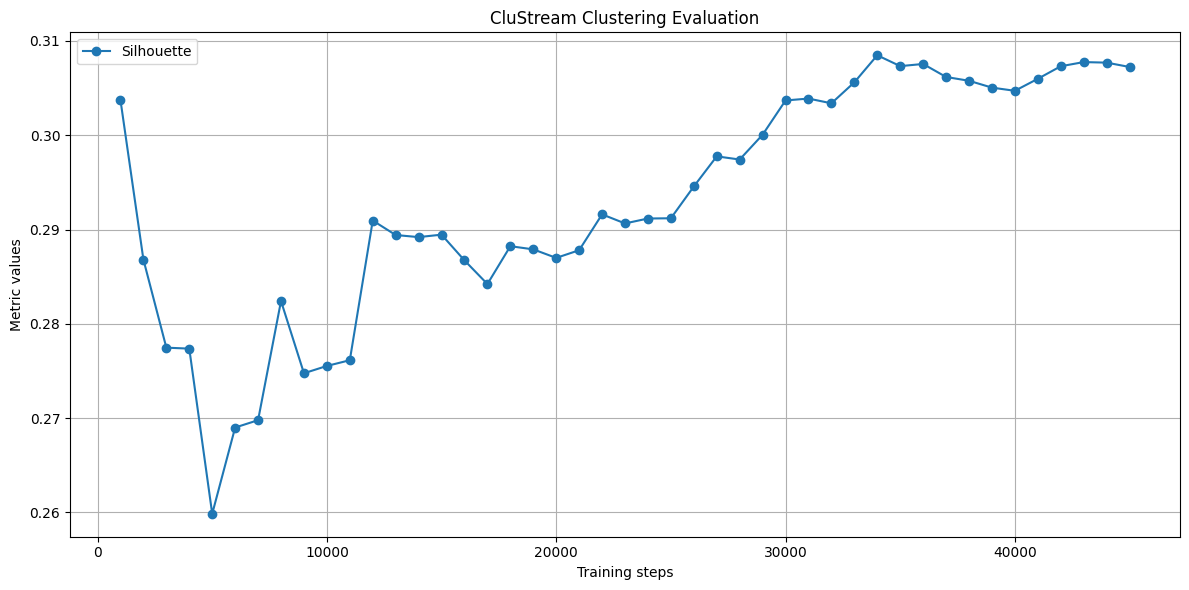

In [45]:
plot_evaluation_results(
    clustream_steps,
    clustream_results,
    metric_names=["Silhouette"],
    figure_title="CluStream Clustering Evaluation",
)

In [39]:
datatset_stream = datasets.Elec2()
denstream_model = cluster.DenStream()
metrics_list = [metrics.Silhouette()]

denstream_steps, denstream_results = train_clustering(
    denstream_model, datatset_stream, metrics_list
)

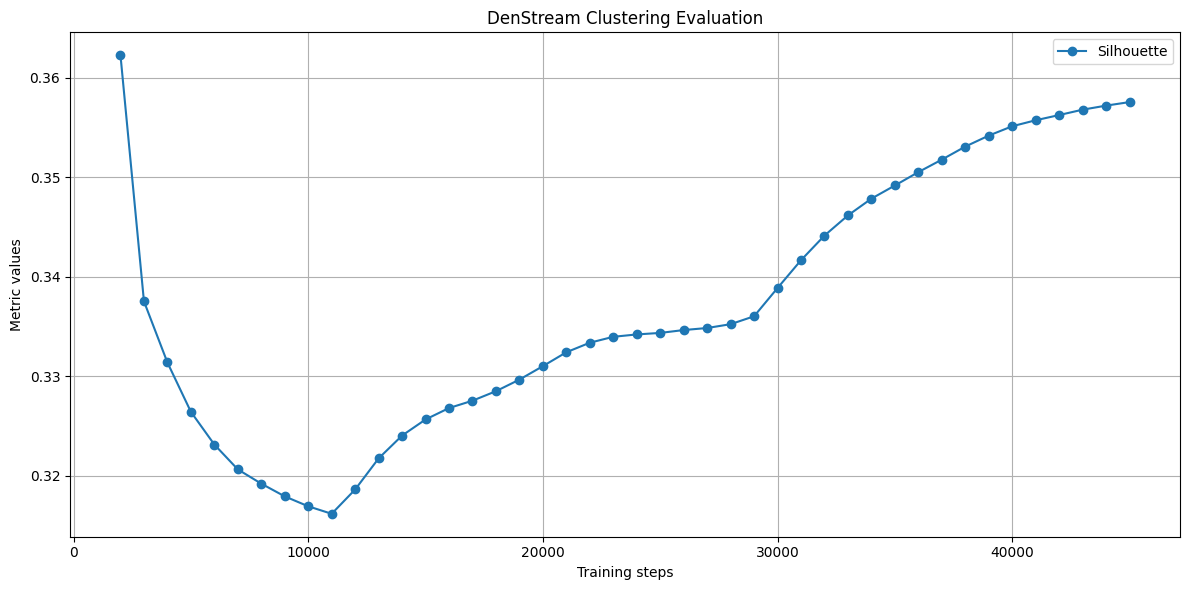

In [40]:
plot_evaluation_results(
    denstream_steps,
    denstream_results,
    metric_names=["Silhouette"],
    figure_title="DenStream Clustering Evaluation",
)

In [46]:
#| include: false
#| echo: false

denstream_results = denstream_results[1:]

,Model,Mean Silhouette,Last Silhouette
0,CluStream,29.30%,30.72%
1,DenStream,33.70%,35.75%


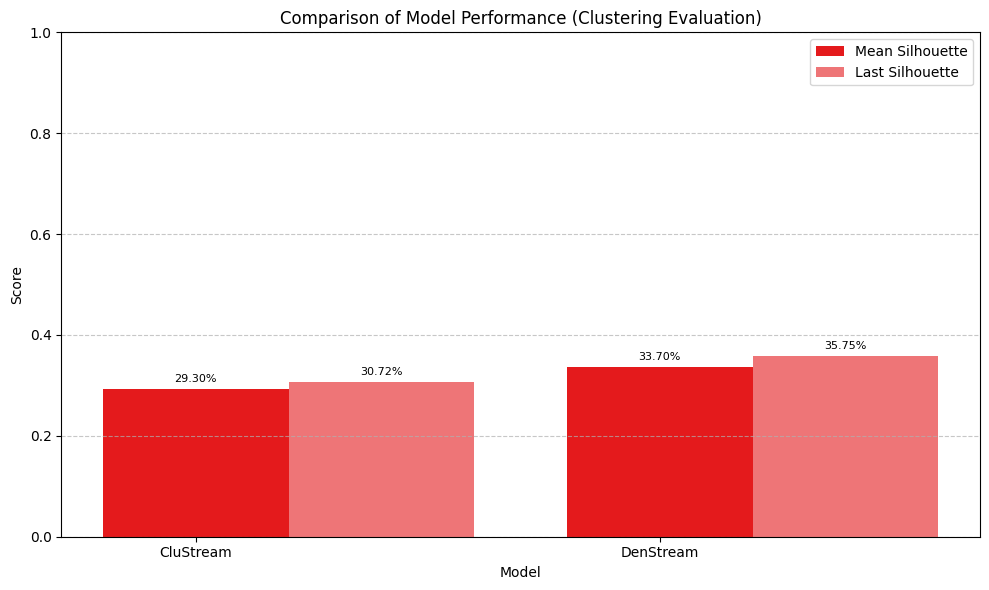

In [47]:
compare_model_results(
    model_names=["CluStream", "DenStream"],
    results_list=[clustream_results, denstream_results],
    metric_names=["Silhouette"],
    evaluation_type="clustering",
)